In [1]:
from glob import glob 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp
import pandas as pd
import numpy as np
import sys
sys.path += ["../src"]
import causal_model
import climact_utils as cu
from itertools import combinations

/home/jacopo.lenti/miniconda3/envs/climact_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I run a set of experiments in a grid where I vary (lr, init_scale, init_scale_opinions, var_opinions).
I choose the set (lr, init_scale, init_scale_opinions) such that I get positive effects $SYM \rightarrow A$.

Moreover, I validate on $SD_{user} \rightarrow SYM$ (partisan).

### get data

In [2]:
len(sorted(glob(causal_model.path_to_exp + "*_240927_*_*")))

420

In [5]:
file = sorted(glob(causal_model.path_to_exp + "activism_240927_*_*"))[0]

In [33]:
model_settings, betas,  = pd.read_pickle(file)["model_settings"], pd.read_pickle(file)["betas"]
model_settings["loss"] = pd.read_pickle(file)["losses"][-1].item()

In [37]:
setting_vars = ["subreddit_class", "lr", "var_opinions", "init_scale", "init_scale_opinions", "num_epochs_early_stop", "loss", "time"]
pd.Series([model_settings[k] for k in setting_vars], index = setting_vars)

subreddit_class            activism
lr                              0.1
var_opinions                   0.01
init_scale                    0.001
init_scale_opinions          0.0001
num_epochs_early_stop           840
loss                     1049082.75
time                     105.036488
dtype: object

In [45]:
betas["beta_to_opinions"][[u for u in betas["beta_to_opinions"].index if (u in cu.sociodemo_classes) or ("norm" in u)]].rename(lambda x: x + "_to_opinion")

age_to_opinion                                  0.0
gender_to_opinion                               0.0
partisan_to_opinion                             0.0
affluence_to_opinion                            0.0
norm_climate_long_to_opinion                    0.0
norm_climate_action_long_to_opinion      -0.6988957
norm_natural_disaster_long_to_opinion           0.0
dtype: object

In [46]:
betas["beta_to_activation"][:8].rename(lambda x: x + "_to_activation")

opinion_to_activation                         0.11480627
norm_climate_long_to_activation                      0.0
norm_climate_action_long_to_activation       -0.35800654
norm_natural_disaster_long_to_activation      0.30883133
norm_climate_short_to_activation                     0.0
norm_climate_action_short_to_activation       0.44920307
norm_natural_disaster_short_to_activation            0.0
interaction_short_to_activation                0.9553369
dtype: object

In [47]:
betas["beta_to_interaction"][cu.sociodemo_classes].rename(lambda x: x + "_to_interaction")

age_to_interaction          0.54684806
gender_to_interaction        -0.547219
partisan_to_interaction     -0.9070984
affluence_to_interaction    -0.5775667
dtype: object

### data analysis

In [3]:
[u for u in pd.read_pickle(sorted(glob(causal_model.path_to_exp + "activism*hyper*_241001_*"))[0])["betas"]["beta_to_opinions"].index if (u in cu.sociodemo_classes) or ("norm" in u)]

['age',
 'gender',
 'partisan',
 'affluence',
 'norm_climate_long',
 'norm_climate_action_long',
 'norm_natural_disaster_long']

In [4]:
def get_experiments_data(file, vars_to_opinions = ['age','gender','partisan','affluence','norm_climate_long','norm_climate_action_long','norm_natural_disaster_long']):
    pickle = pd.read_pickle(file)
    model_settings, betas,  = pickle["model_settings"], pickle["betas"]
    # model_settings["loss"] = pd.read_pickle(file)["losses"][-1].item()
    setting_vars = ["subreddit_class", "lr", "var_opinions", "init_scale", "init_scale_opinions", "num_epochs_early_stop", "loss", "time", "accuracy_mean", "accuracy_std"]
    settings_s = pd.Series([model_settings[k] for k in setting_vars], index = setting_vars)
    opinions_s = betas["beta_to_opinions"][vars_to_opinions].rename(lambda x: x + "_to_opinion")
    activation_s = betas["beta_to_activation"][:8].rename(lambda x: x + "_to_activation")
    interaction_s = betas["beta_to_interaction"][cu.sociodemo_classes].rename(lambda x: x + "_to_interaction")
    return pd.concat([settings_s, opinions_s, activation_s, interaction_s])


### lr, init_scale, init_scale_opinions, var_opinions

In [1]:
# 34 mins 41
data_exp = pd.DataFrame([get_experiments_data(file) for file in sorted(glob(causal_model.path_to_exp + "activism*hyper*_241001_*"))])


In [80]:
# data_exp["subreddit_class"] = [u.split("/")[-1].split("_")[0] for u in sorted(glob(causal_model.path_to_exp + "*_240927_*_*"))]

In [6]:
# data_exp.to_csv(causal_model.path_to_exp + "hyperparameter_tuning_activism_241001.csv")
data_exp = pd.read_csv(causal_model.path_to_exp + "hyperparameter_tuning_activism_241001.csv", index_col = 0)

In [33]:
best_data = data_exp.sort_values("accuracy_mean", ascending = False).groupby(["lr", "var_opinions", "init_scale", "init_scale_opinions"]).first().reset_index()

In [34]:
data_dict = {subreddit_class: best_data.set_index("subreddit_class").loc[subreddit_class] for subreddit_class in ["activism"]} #cu.subreddit_classes}

In [35]:
subreddit_class = "activism"

In [36]:
(np.abs(data_dict[subreddit_class]) > 0).mean()

lr                                           1.000000
var_opinions                                 1.000000
init_scale                                   1.000000
init_scale_opinions                          1.000000
num_epochs_early_stop                        1.000000
loss                                         1.000000
time                                         1.000000
accuracy_mean                                1.000000
accuracy_std                                 1.000000
age_to_opinion                               0.502778
gender_to_opinion                            0.041667
partisan_to_opinion                          0.575000
affluence_to_opinion                         0.658333
norm_climate_long_to_opinion                 0.002778
norm_climate_action_long_to_opinion          0.244444
norm_natural_disaster_long_to_opinion        0.008333
opinion_to_activation                        0.961111
norm_climate_long_to_activation              0.272222
norm_climate_action_long_to_

#### Loss

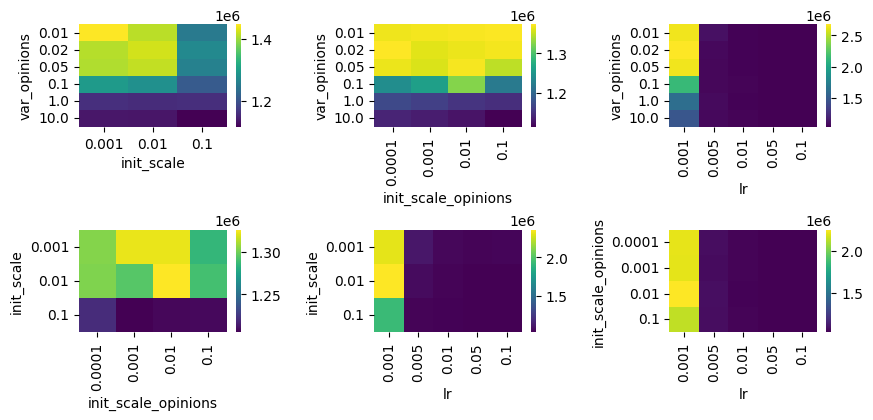

In [37]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

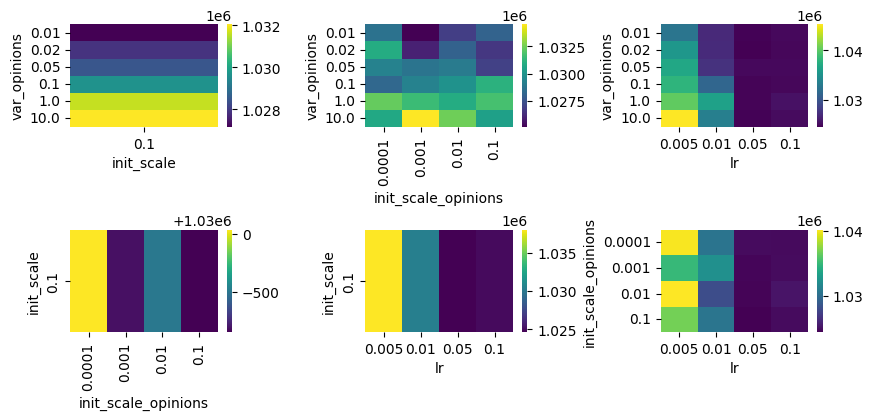

In [38]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr > 0.001)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

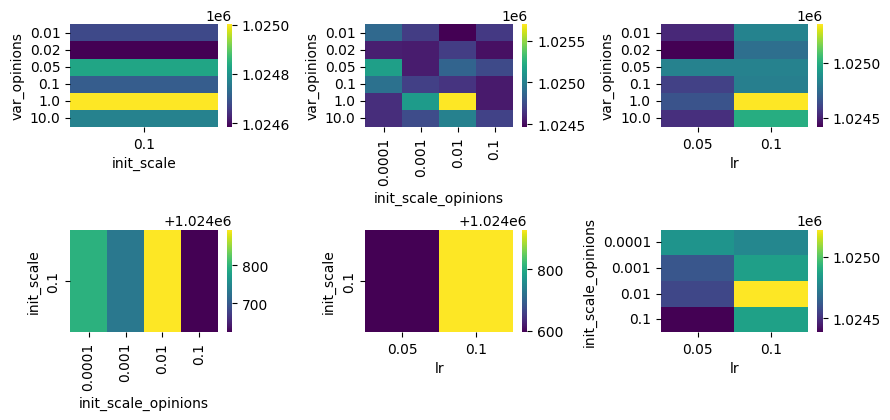

In [40]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr > 0.01)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

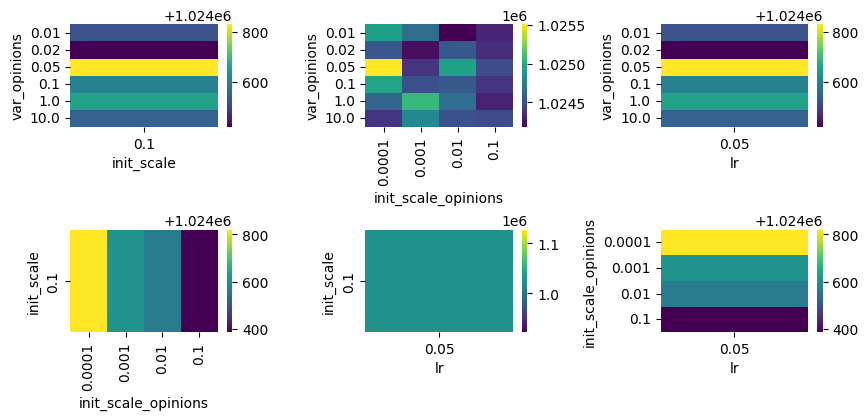

In [41]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr == 0.05)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

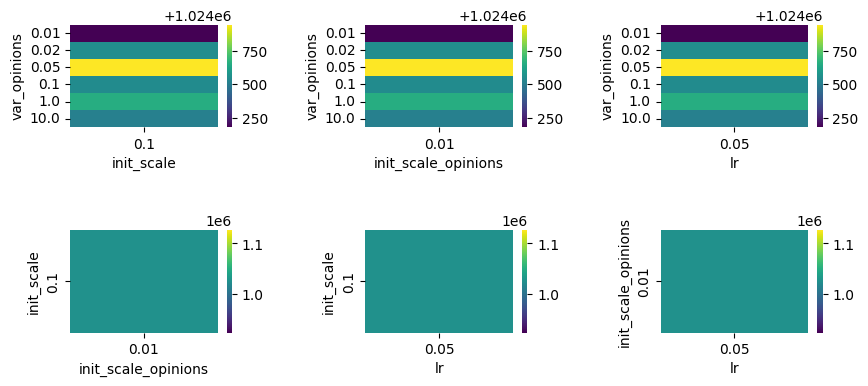

In [46]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(init_scale_opinions == 0.01)&(lr == 0.05)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

#### Accuracy

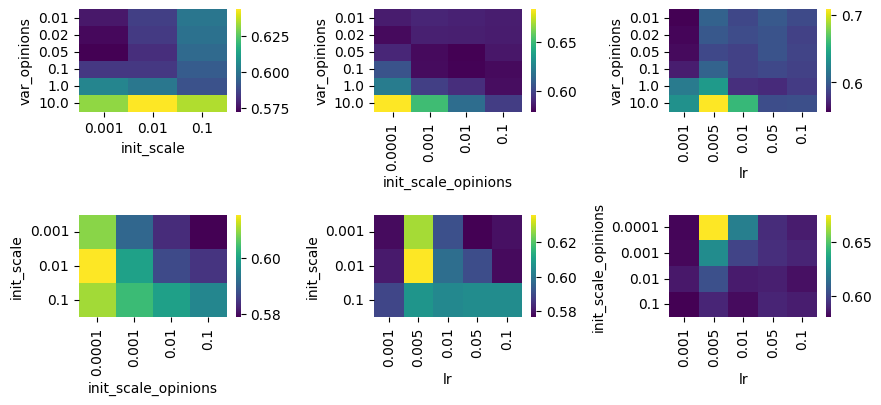

In [47]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].set_index([v1,v2])["accuracy_mean"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

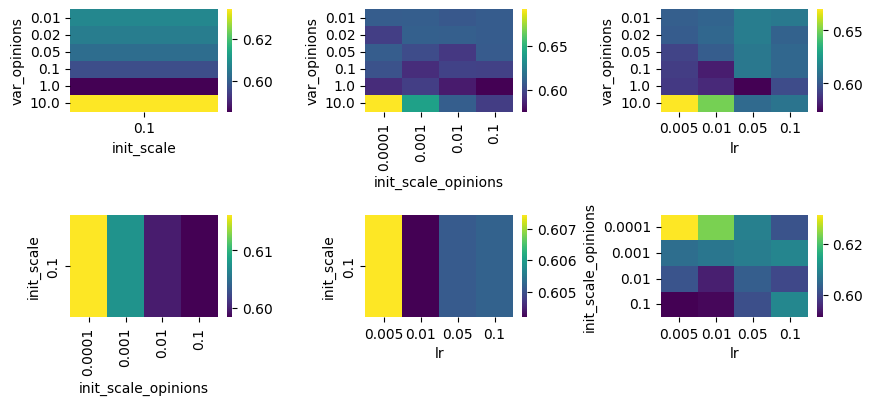

In [49]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr > 0.001)").set_index([v1,v2])["accuracy_mean"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

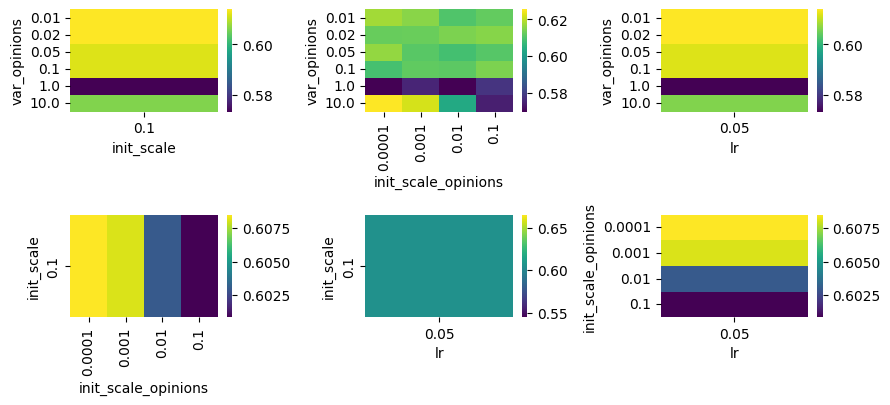

In [50]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr == 0.05)").set_index([v1,v2])["accuracy_mean"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

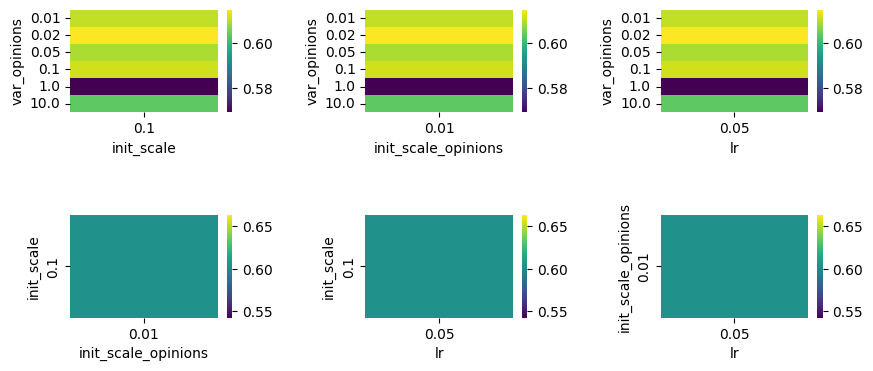

In [54]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 4))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(init_scale_opinions == 0.01)&(lr == 0.05)").set_index([v1,v2])["accuracy_mean"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

In [36]:
data_dict["activism"].query("(lr == 0.01)&(init_scale == 0.1)&(init_scale_opinions == 0.01)")["opinion_to_activation"]

subreddit_class
activism    0.064889
activism    0.507992
activism    0.270711
activism    0.718761
activism    0.405168
activism    0.294591
activism    0.346006
activism    0.292426
activism    0.283998
activism    0.284621
activism    0.295298
activism    0.288212
activism    0.316177
activism    0.313052
activism    0.324302
activism    0.754834
activism    0.830720
activism    0.504111
activism    0.599020
activism    0.423148
Name: opinion_to_activation, dtype: float64

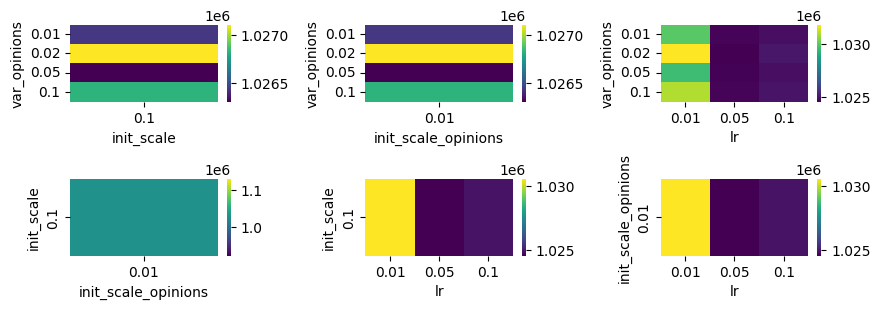

In [ ]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(init_scale_opinions == 0.01)&(lr > 0.005)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

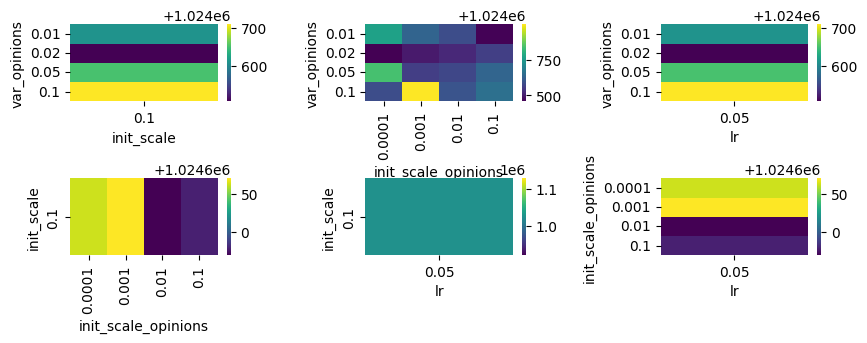

In [ ]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap(data_dict[subreddit_class].query("(init_scale == 0.1)&(lr == 0.05)").set_index([v1,v2])["loss"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

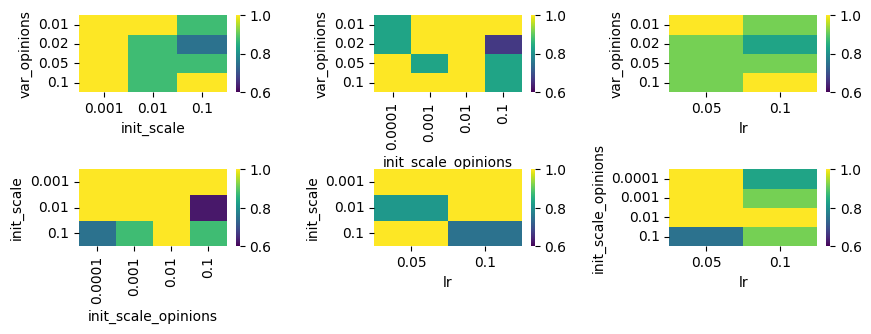

In [ ]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].set_index([v1,v2]) > 0)["opinion_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0.6, vmax = 1., cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

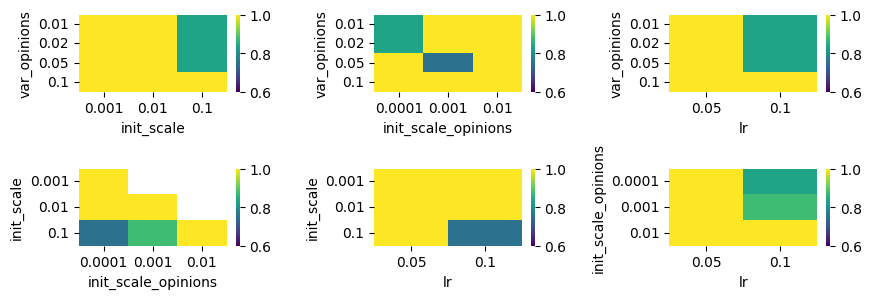

In [43]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions < init_scale)").set_index([v1,v2]) > 0)["opinion_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0.6, vmax = 1., cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

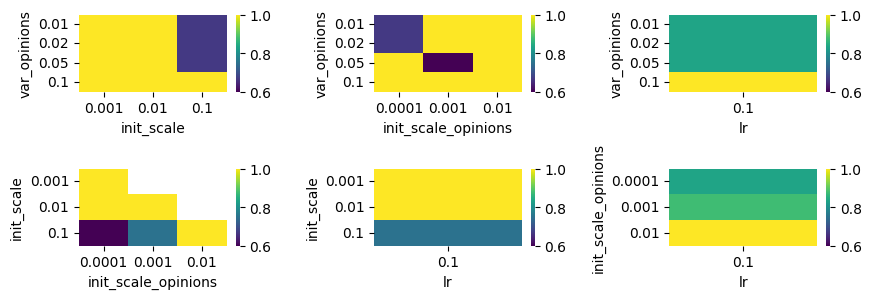

In [48]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions < init_scale)&(lr == 0.1)").set_index([v1,v2]) > 0)["opinion_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0.6, vmax = 1., cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

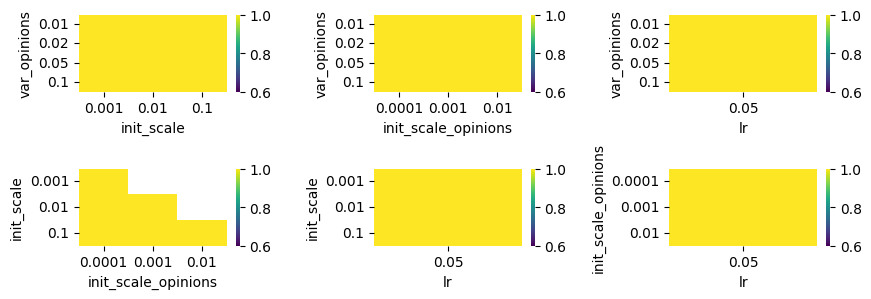

In [49]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions < init_scale)&(lr == 0.05)").set_index([v1,v2]) > 0)["opinion_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0.6, vmax = 1., cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

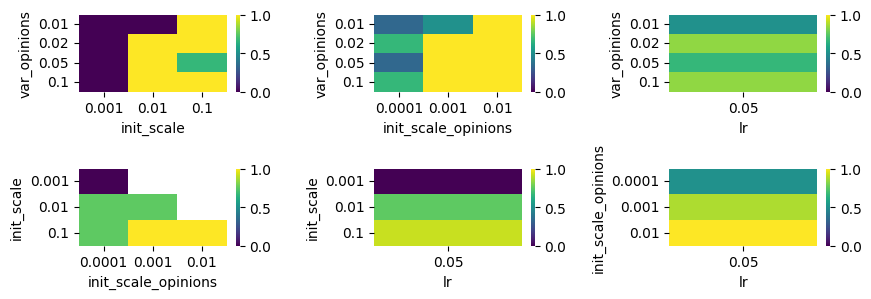

In [50]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions < init_scale)&(lr == 0.05)").set_index([v1,v2]) < 0)["partisan_to_opinion"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

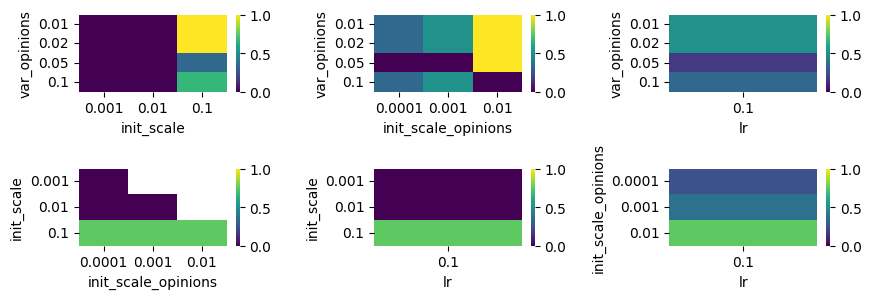

In [52]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions < init_scale)&(lr == 0.1)").set_index([v1,v2]) < 0)["partisan_to_opinion"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

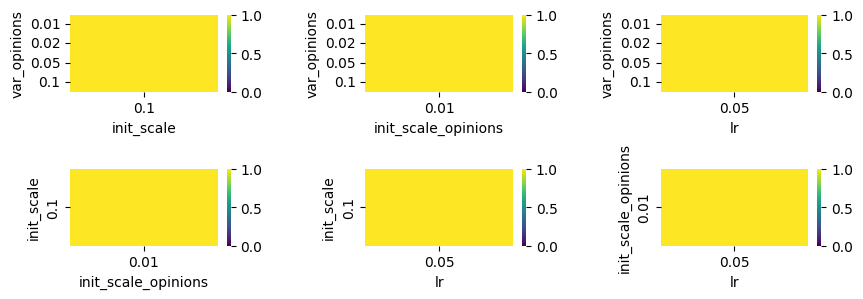

In [53]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions == 0.01)&(init_scale == 0.1)&(lr < 0.1)").set_index([v1,v2]) < 0)["partisan_to_opinion"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

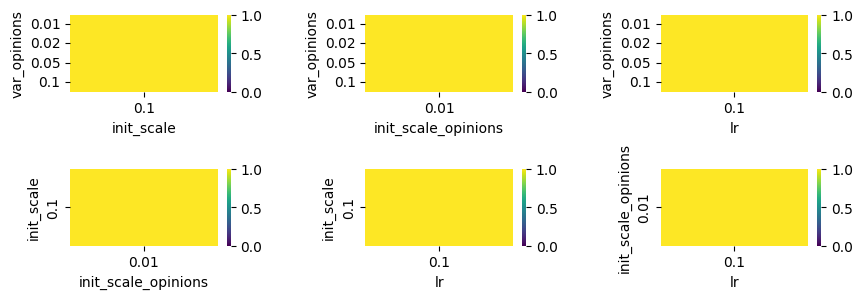

In [54]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale_opinions == 0.01)&(init_scale == 0.1)&(lr == 0.1)").set_index([v1,v2]) > 0)["opinion_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

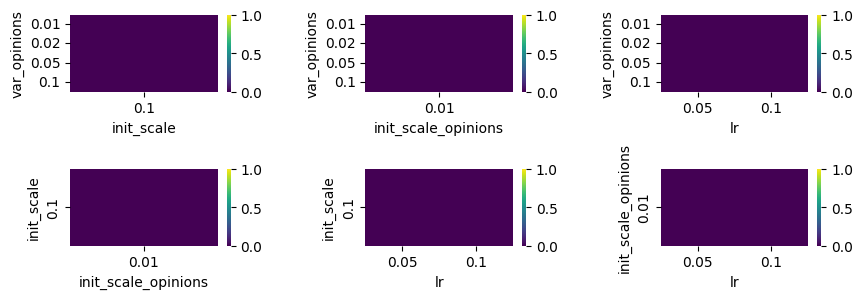

In [60]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(init_scale == 0.1)&(init_scale_opinions == 0.01)").set_index([v1,v2]) > 0)["norm_natural_disaster_long_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

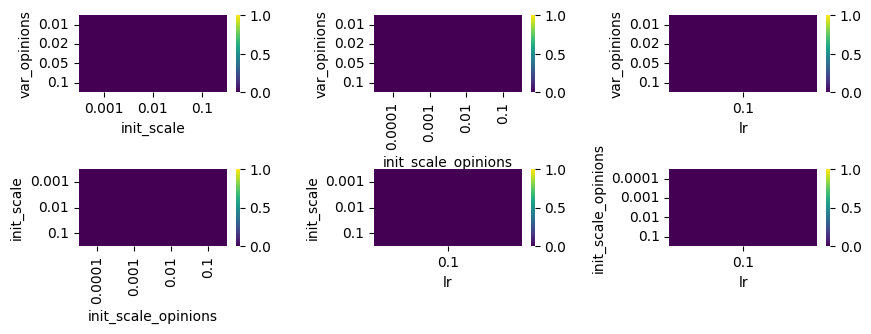

In [57]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(lr == 0.1)").set_index([v1,v2]) > 0)["norm_climate_long_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

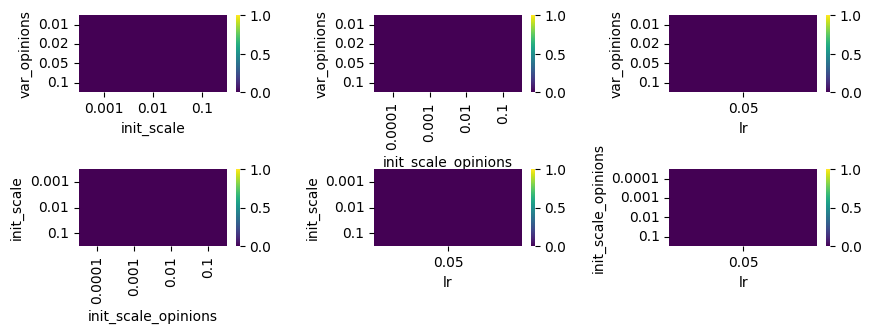

In [59]:
fig, axes = sbp(ncols = 3, nrows = 2, figsize = (10, 3))
fig.subplots_adjust(wspace=0.6, hspace=1.)
for k, (v1, v2) in enumerate(combinations(["var_opinions", "init_scale", "init_scale_opinions", "lr"], 2)):
    i,j = round((k-1)/3), k % 3
    sns.heatmap((data_dict[subreddit_class].query("(lr == 0.05)").set_index([v1,v2]) > 0)["norm_climate_long_to_activation"].groupby([v1, v2]).mean().unstack(),
                ax = axes[i,j], vmin = 0., vmax = 1., 
                cmap = "viridis")
    axes[i,j].set_ylabel(v1)
    axes[i,j].set_xlabel(v2)
    

In [65]:
data_exp.query("(norm_natural_disaster_long_to_activation > 0)&(opinion_to_activation > 0)&(partisan_to_opinion < 0)").T

""
subreddit_class
lr
var_opinions
init_scale
init_scale_opinions
num_epochs_early_stop
loss
time
age_to_opinion
gender_to_opinion


In [196]:
((data_dict[subreddit_class].query("(init_scale == 0.1)&(lr == 0.05)").set_index([v1,v2])) > 0).mean()

var_opinions                                 1.0000
init_scale                                   1.0000
num_epochs_early_stop                        1.0000
loss                                         1.0000
time                                         1.0000
age_to_opinion                               1.0000
gender_to_opinion                            0.0000
partisan_to_opinion                          0.1875
affluence_to_opinion                         0.7500
norm_climate_long_to_opinion                 0.0000
norm_climate_action_long_to_opinion          0.0000
norm_natural_disaster_long_to_opinion        0.0000
opinion_to_activation                        1.0000
norm_climate_long_to_activation              0.0000
norm_climate_action_long_to_activation       1.0000
norm_natural_disaster_long_to_activation     0.0000
norm_climate_short_to_activation             0.0000
norm_climate_action_short_to_activation      0.0000
norm_natural_disaster_short_to_activation    0.0000
interaction_

### exp early stop

1000
1025031.4
1130
1024912.56
1150
1024718.25
1490
1024779.0
1440
1024811.2
1600
1024709.44
4600
1025317.5
2640
1024872.06
8660
1025637.56


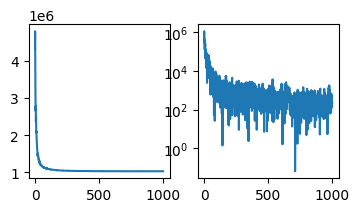

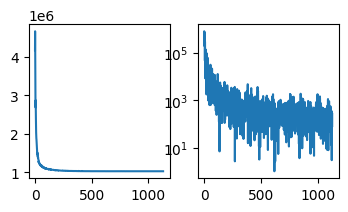

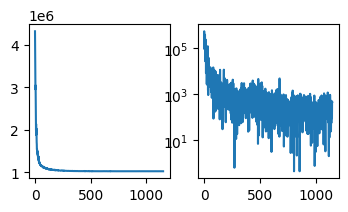

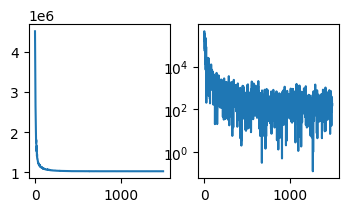

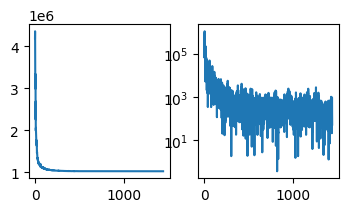

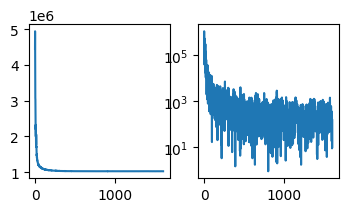

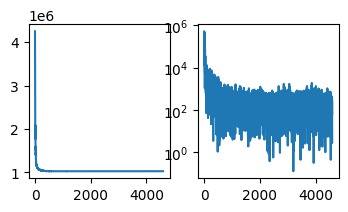

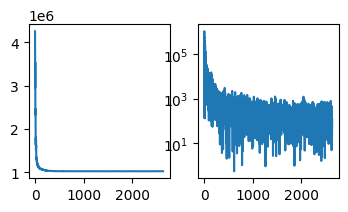

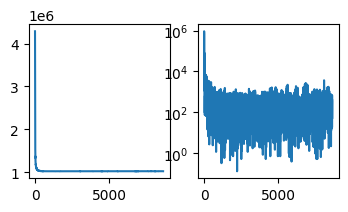

In [206]:
exp_early_stop = []
for delta_loss in [100, 50, 10]:
    for delta_params in [1., 0.5, 0.1]:
        guide, svi_results, betas = causal_model.full_experiment(subreddit_class = "activism", 
                                                                    n_epochs = 10000, 
                                                                    lr = 0.1,
                                                                    var_opinions = 0.01, 
                                                                    multivariate = True, 
                                                                    date = "240928", 
                                                                    progress_bar = False, 
                                                                    id = f"dl{delta_loss}_dp{delta_params * 10}", 
                                                                    print_loss = True, 
                                                                    save = True, 
                                                                    return_res = True, 
                                                                    init_scale = 0.1, 
                                                                    init_scale_opinions = 0.001, 
                                                                    early_stop = True,
                                                                    early_stop_params = {"delta_loss": delta_loss, "delta_params": delta_params})
        
        exp_early_stop.append([delta_loss, delta_params, betas])
            

In [240]:
[(pd.read_pickle(file)["betas"]["beta_to_activation"]["opinion"], pd.read_pickle(file)["model_settings"]["num_epochs_early_stop"]) for file in sorted(glob(causal_model.path_to_exp+ "act*dl*dp*"))]

[(Array(0.04125754, dtype=float32), 1150),
 (Array(0.30619395, dtype=float32), 1000),
 (Array(0.24085848, dtype=float32), 1130),
 (Array(0., dtype=float32), 8660),
 (Array(0., dtype=float32), 4600),
 (Array(0.2654671, dtype=float32), 2640),
 (Array(0.25921905, dtype=float32), 1600),
 (Array(0.03318868, dtype=float32), 1490),
 (Array(0.2645308, dtype=float32), 1440)]

<Axes: xlabel='None', ylabel='None'>

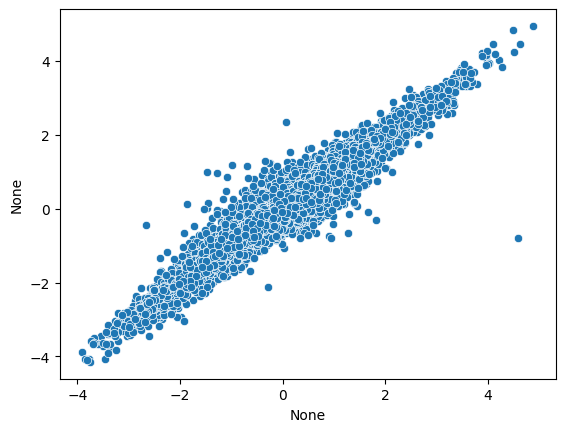

In [230]:
sns.scatterplot(x = pd.read_pickle(sorted(glob(causal_model.path_to_exp+ "act*dl100_*dp10.*"))[0])["betas"]["sociodemo_users"].stack(),
y = pd.read_pickle(sorted(glob(causal_model.path_to_exp+ "act*dl10_*dp1.*"))[0])["betas"]["sociodemo_users"].stack())

<Axes: xlabel='None', ylabel='None'>

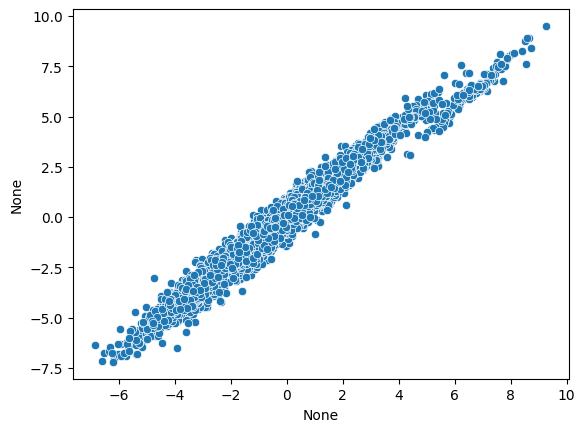

In [237]:
sns.scatterplot(x = pd.read_pickle(sorted(glob(causal_model.path_to_exp+ "act*dl100_*dp1.*"))[0])["betas"]["opinions_median"],
y = pd.read_pickle(sorted(glob(causal_model.path_to_exp+ "act*dl10_*dp10.*"))[0])["betas"]["opinions_median"])

### var_opinions, init_scale_opinions

In [171]:
# 1 min
data_exp = pd.DataFrame([get_experiments_data(file) for file in sorted(glob(causal_model.path_to_exp + "activism*_240928_*"))])


In [15]:
data_exp.to_csv(causal_model.path_to_exp + "hyperparameter_tuning_270928.csv")

In [16]:
data_exp[["var_opinions", "init_scale_opinions", "init_scale", "subreddit_class", "lr"]].value_counts()

var_opinions  init_scale_opinions  init_scale  subreddit_class  lr  
0.01          0.0001               0.1         action           0.05    1
                                               activism         0.05    1
                                               discussion       0.05    1
                                               skeptic          0.05    1
              0.0010               0.1         action           0.05    1
                                               activism         0.05    1
                                               discussion       0.05    1
                                               skeptic          0.05    1
              0.0100               0.1         action           0.05    1
                                               activism         0.05    1
                                               discussion       0.05    1
                                               skeptic          0.05    1
0.02          0.0001               0.1     

In [172]:
data_dict = {subreddit_class: data_exp.set_index("subreddit_class").loc[subreddit_class] for subreddit_class in ["activism"]} #cu.subreddit_classes}

In [18]:
subreddit_class = "activism"

In [173]:
(np.abs(data_dict[subreddit_class]) > 0).mean()

lr                                           1.000000
var_opinions                                 1.000000
init_scale                                   1.000000
init_scale_opinions                          1.000000
num_epochs_early_stop                        1.000000
loss                                         1.000000
time                                         1.000000
age_to_opinion                               1.000000
gender_to_opinion                            0.000000
partisan_to_opinion                          1.000000
affluence_to_opinion                         1.000000
norm_climate_long_to_opinion                 0.000000
norm_climate_action_long_to_opinion          0.190476
norm_natural_disaster_long_to_opinion        0.000000
opinion_to_activation                        0.904762
norm_climate_long_to_activation              0.047619
norm_climate_action_long_to_activation       1.000000
norm_natural_disaster_long_to_activation     0.047619
norm_climate_short_to_activa

In [174]:
data_dict[subreddit_class].assign(signif_opinion_to_activation = lambda x: data_dict[subreddit_class]["opinion_to_activation"] > 0).groupby("signif_opinion_to_activation").mean().T

signif_opinion_to_activation,False,True
lr,0.1,0.068421
var_opinions,0.01,0.032105
init_scale,0.1,0.1
init_scale_opinions,0.001,0.002705
num_epochs_early_stop,6630.0,1837.368421
loss,1025477.53125,1024583.407895
time,638.957403,202.078454
age_to_opinion,0.02328,0.99005
gender_to_opinion,0.0,0.0
partisan_to_opinion,-0.043116,-1.752784


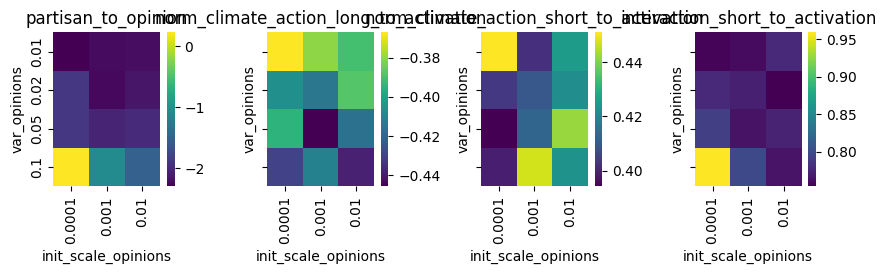

In [41]:
fig, axes = sbp(ncols = 4, nrows = 1, figsize = (10, 2), sharex = True, sharey = True)
fig.subplots_adjust(wspace=0.6, hspace=1.)

for k, v in enumerate(["partisan_to_opinion", "norm_climate_action_long_to_activation", "norm_climate_action_short_to_activation", "interaction_short_to_activation"]):
    sns.heatmap(data_dict[subreddit_class].groupby(["var_opinions", "init_scale_opinions"]).mean()[v].unstack().astype(float),
                ax = axes[k], cmap = "viridis")
    axes[k].set_title(v)
    
    

In [205]:
data_exp = pd.DataFrame([get_experiments_data(file) for file in sorted(glob(causal_model.path_to_exp + "*_240930A*"))])


In [206]:
data_exp

,subreddit_class,lr,var_opinions,init_scale,init_scale_opinions,num_epochs_early_stop,loss,time,age_to_opinion,gender_to_opinion,...,norm_climate_action_long_to_activation,norm_natural_disaster_long_to_activation,norm_climate_short_to_activation,norm_climate_action_short_to_activation,norm_natural_disaster_short_to_activation,interaction_short_to_activation,age_to_interaction,gender_to_interaction,partisan_to_interaction,affluence_to_interaction
0,activism,0.01,0.01,0.01,0.01,2940,1.032123e+06,314.519332,0.49487847,0.0,...,-0.4548206,0.0,0.0,0.40865648,0.0,0.8811847,0.60437626,-0.53017384,-0.898012,-0.52849346
1,activism,0.01,0.01,0.01,0.01,2620,1.036120e+06,283.591374,0.0,0.0,...,-0.4674626,0.0,0.0,0.40912277,0.0,0.8856194,0.63659793,-0.52813876,-0.890849,-0.53126585
2,activism,0.01,0.01,0.01,0.01,2880,1.032732e+06,308.967322,0.48726657,0.0,...,-0.4569308,0.0,0.0,0.4151355,0.0,0.85236627,0.6301101,-0.507654,-0.9263388,-0.5313719
3,activism,0.01,0.01,0.01,0.01,2270,1.042811e+06,247.804186,0.62067413,0.3527562,...,-0.44310817,0.0,0.0,0.41937867,0.0,0.8455224,0.63847065,-0.51432675,-0.89845175,-0.5395113
4,activism,0.01,0.01,0.01,0.01,2370,1.040567e+06,258.626319,0.0,0.0,...,-0.45414835,0.0,0.0,0.3973334,0.0,0.88190216,0.63212746,-0.5210928,-0.8914618,-0.534787
5,activism,0.01,0.01,0.01,0.01,3010,1.031494e+06,324.324871,0.49661338,0.0,...,-0.4452471,0.0,0.0,0.42019728,0.0,0.8653112,0.61498827,-0.5010792,-0.8828641,-0.52521145
6,activism,0.01,0.02,0.01,0.01,3580,1.027744e+06,381.304025,0.79277,0.0,...,-0.431817,0.0,0.0,0.40735182,0.0,0.8220691,0.6142567,-0.5291879,-0.87865037,-0.54286397
7,activism,0.01,0.02,0.01,0.01,2440,1.039014e+06,268.854806,0.0,0.0,...,-0.43925333,0.0,0.0,0.4157937,0.0,0.9368214,0.63151145,-0.51752996,-0.9288761,-0.5173391
8,activism,0.01,0.02,0.01,0.01,2810,1.033796e+06,305.372103,0.0,0.0,...,-0.45660692,0.0,0.0,0.42060983,0.0,0.88424116,0.606184,-0.51776576,-0.897175,-0.5370726
9,activism,0.01,0.02,0.01,0.01,2300,1.041982e+06,268.452055,0.0,0.36261734,...,-0.44805032,0.0,0.0,0.40321198,0.0,0.89390755,0.60716164,-0.5244202,-0.913117,-0.527945
